In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import spearmanr as spearman
pilot_file = "Batch_3220834_batch_results.csv"

In [2]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]
#data.head()

In [3]:
data.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input_var_arrays',
       'Answer_comments', 'Answer_confidence_range1',
       'Answer_confidence_range10', 'Answer_confidence_range2',
       'Answer_confidence_range3', 'Answer_confidence_range4',
       'Answer_confidence_range5', 'Answer_confidence_range6',
       'Answer_confidence_range7', 'Answer_confidence_range8',
       'Answer_confidence_range9', 'Answer_dummy', 'Answer_sld_pred1_1',
       'Answer_sld_pred1_10', 'Answer_sld_pred1_2', 'A

In [4]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_pred1 = "Answer_sld_pred1_" + str(idx+1)
            var_pred2 =  "Answer_sld_pred2_" + str(idx+1)
            var_conf = "Answer_confidence_range" + str(idx+1)
            
            temp_dict["slider1_posn"] = getattr(row, var_pred1)
            temp_dict["slider2_posn"] = getattr(row, var_pred2)
            temp_dict["confidence"] = getattr(row, var_conf)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)

In [5]:
pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)


#Drop start, end, instant variables that were stored in the json data
pilot_data = pilot_data.drop(['start_pred1', 'start_pred2', 'end_pred1', 'end_pred2',
                             'instant_pred1', 'instant_pred2'], axis=1)


#pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head
pilot_data['sent_token'] = pilot_data['sentence_id'] + "_" +\
                            pilot_data['pred_token1'].map(lambda x: str(x)) + "_" +\
                             pilot_data['pred_token2'].map(lambda x: str(x))

In [6]:
print(pilot_data.shape)
pilot_data.head()

(500, 12)


,worker_id,slider2_posn,slider1_posn,sentence_id,pred_token2,pred_token1,pred2,pred1,id,hit_id,confidence,sent_token
0,AURYD2FH3FUOQ,27 - 46,39 - 46,en-ud-train.conllu 13,16,4,way,kidnapped,1,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,3,en-ud-train.conllu 13_4_16
1,AURYD2FH3FUOQ,6 - 17,25 - 41,en-ud-train.conllu 46,26,6,leave,putting,2,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,1,en-ud-train.conllu 46_6_26
2,AURYD2FH3FUOQ,19 - 26,35 - 37,en-ud-train.conllu 60,14,3,shooting,make,3,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,0,en-ud-train.conllu 60_3_14
3,AURYD2FH3FUOQ,57 - 80,35 - 36,en-ud-train.conllu 65,57,1,dragged,added,4,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,2,en-ud-train.conllu 65_1_57
4,AURYD2FH3FUOQ,15 - 16,10 - 16,en-ud-train.conllu 118,34,7,started,had,5,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,2,en-ud-train.conllu 118_7_34


In [7]:
def time_ml_tag(row, var1, var2):
    '''
    Creates time ML tags from slider positions of two events 
    
    Eg: EVENT 1 "is before" EVENT2
    
    Eg: Relatins: is before
    '''
    ans = ""
    
    slider1 = getattr(row, var1)
    slider2 = getattr(row, var2)
    
    event1 = [int(x) for x in slider1.split("-")]
    event2 = [int(x) for x in slider2.split("-")]
    
    if (event1[0] == event2[0]) and (event1[1] == event2[1]):
        ans = "simultaneous"
        
    elif event1[1] <= event2[0]:
        ans = "before"
    
    elif event1[0] >= event2[1]:
        ans = "after"
        
    elif event1[1] >= event2[1] and event1[0] <= event2[0]:
        ans = "includes"
        
    elif event1[1] <= event2[1] and event1[0] >= event2[0]:
        ans = "is_included"
    
    elif event1[0] < event2[0] and event1[1] > event2[0]:
        ans = "before_cont"
        
    elif event1[0] < event2[1] and event1[1] > event2[1]:
        ans = "after_cont"
    
    else: 
        ans = "other"
    
    return ans

In [8]:
pilot_data['timeML_tag'] = pilot_data.apply(lambda row: time_ml_tag(row, 'slider1_posn', 'slider2_posn'), axis=1)

before          263
after            73
includes         60
is_included      56
simultaneous     23
before_cont      14
after_cont       11
Name: timeML_tag, dtype: int64


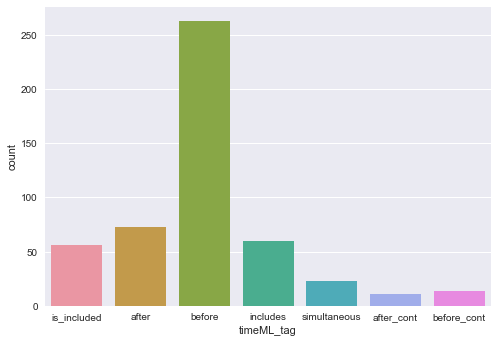

In [9]:
print(pilot_data.timeML_tag.value_counts())
sns.countplot(x='timeML_tag', data=pilot_data)
plt.show()


## Inter-Annotator Agreement

#### Raw Agreement

In [10]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys



In [11]:
instant_agreement, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag')

####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 100
Raw count of matched for timeML_tag is 22
Inter-annotator agreement for timeML_tag is 22.0%




### Kappa estimation 

In [12]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def extract_worker_pair_dict(data, worker_pairs, worker_dict, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    ans = {}
    
    for (w1, w2) in worker_pairs:
        common_set = worker_dict[w1].intersection(worker_dict[w2])
        if common_set != set():
            ans[(w1,w2)] = list(common_set)
        
    return ans

In [13]:
worker_pairs = extract_pairs_of_workers(pilot_data, 'worker_id')
worker_dict = extract_worker_sent_dict(pilot_data, 'worker_id', 'sent_token')
worker_pair_dict = extract_worker_pair_dict(pilot_data, worker_pairs, worker_dict,'sent_token')

In [14]:
def average_metric_sklearn(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp1.append(val3[0])
            temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue

        elif temp1==temp2:
            kappas.append(1.0)
        else:
            kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
                
    return kappas, accuracies

In [15]:
kappas = {}
accuracies = {}
vars_temp = ['timeML_tag']
for var in vars_temp:
    kappas[var], accuracies[var] = average_metric_sklearn(pilot_data, 'worker_id', 'sent_token', var)
    print("{} -- Completed!".format(var))

timeML_tag -- Completed!


In [16]:
kappa_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kappas.items() ]))
acc_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in accuracies.items() ]))

In [17]:
print('Average Kappa for "timeML_tag" variable: {}'.format(np.mean(kappa_data['timeML_tag'])))
print("\n")

print('Average Accuracy for "timeML_tag" variable: {}'.format(np.mean(acc_data['timeML_tag'])))
print("\n")

Average Kappa for "timeML_tag" variable: 0.18573327643520413


Average Accuracy for "timeML_tag" variable: 0.4454113924050633


